Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:


In [ ]:
NAME = "Piotr Durniat"

---


In [1]:
from typing import Callable, List, Tuple

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import distributions as ptdist

torch.manual_seed(2021)

In [2]:
def plot_param_values(
    sample_sizes: List[int],
    param_values: List[float],
    true_param_value: float,
    title: str,
):
    """Plots changes of parameter value for different sampling sizes."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

    x, y = sample_sizes, param_values

    ax.plot(
        x,
        y,
        marker="o",
        ms=3,
        linestyle="",
        color="green",
        label="Estymator",
    )
    ax.plot(x, y, marker="", linestyle="--", alpha=0.2)

    ax.axhline(
        true_param_value,
        linestyle="--",
        color="blue",
        label="Rzeczywista wartość parametru",
    )
    ax.set_xlabel("Rozmiar próbki")
    ax.set_ylabel("Parametr")
    ax.set_ylim((0, 1))
    ax.legend()

    fig.suptitle(title)


def evaluate_at_intervals(
    data: np.ndarray,
    step: int,
    fn: Callable,
    start: int = 1,
) -> Tuple[List[int], List[float]]:
    sample_sizes = []
    param_values = []

    for idx in range(start, len(data), step):
        sample_sizes.append(idx)
        param_values.append(fn(data, idx))

    return sample_sizes, param_values

# Estymacja parametrów modeli


Źródła: [1](https://web.stanford.edu/class/archive/cs/cs109/cs109.1192/reader/11%20Parameter%20Estimation.pdf) [2](http://www.mi.fu-berlin.de/wiki/pub/ABI/Genomics12/MLvsMAP.pdf)


Dotychczas mówiąc o rozkładach (modelach) zmiennych losowych mieliśmy podane ich parametry, np. zakładaliśmy, że $x \sim N(0,1)$ - zmienna losowa $x$ pochodzi z rozkładu normalnego z parametrami średniej równej 0 oraz odchylenia standardowego równego 1 (rozkład normalny standardowy).

W rzeczywistości rzadko kiedy będziemy mieli informację o rzeczywistych wartościach parametrów, a naszym zadaniem będzie przybliżyć (**wyestymować**) je na podstawie dostępnej **próbki danych**. Na tych zajęciach przeanalizujemy dwa podejścia do estymacji: **Maximum Likelihood Estimation (MLE)** oraz **Maximum a Posteriori (MAP)**.


W poniższych rozważaniach będziemy oznaczać parametry modeli jako $\theta$. Zakładamy, że zbiór danych składa się z $n$ próbek: $(X_1, X_2, \ldots, X_n)$, które są niezależne i pochodzą z tego samego rozkładu prawdopodobieństwa (IID, _ang. independently and identically distributed_).


Przykłady rozkładów oraz parametrów:

| Nazwa           | Oznaczenie                | Parametry                    |
| :-------------- | :------------------------ | :--------------------------- |
| r. Bernoulliego | $$Bernoulli(p)$$          | $$\theta = p$$               |
| r. Poissona     | $$Poisson(\lambda)$$      | $$\theta = \lambda$$         |
| r. jednostajny  | $$Uniform(a, b)$$         | $$\theta = (a, b)$$          |
| r. normalny     | $$Normal(\mu, \sigma^2)$$ | $$\theta = (\mu, \sigma^2)$$ |


## Uwaga: Istnieją różnice w polskiej i angielskiej terminologii nazywania rozkładów prawdopodobieństwa.

W tej liście zadań będziemy korzystać z **rozkładu Bernoulliego**, zdefiniowanego tak jak w anglojęzycznych źródłach. Polskim odpowiednikiem jest "**rozkład zero-jedynkowy**". W celu zachowania zgodności z nazwami występującymi w dostępnych bibliotekach programistycznych **będziemy się posługiwać angielską wersją (czyt: rozkład Bernoulliego)**.


## Maximum Likelihood Estimation


W przypadku tej metody estymacji chcemy uzyskać parametry $\theta$, przy których **obserwowane dane są najbardziej prawdopodobne**.

Oznaczmy **likelihood** naszego rozkładu, niezależnie czy mówimy o rozkładach dyskretnych (funkcja masy prawdopodobieństwa) czy o rozkładach ciągłych (funkcja gęstości prawdopodobieństwa), jako $f(X|\theta)$. Funkcja ta będzie nam określała jak prawdopodobne jest obserwowanie danych $X$ pod warunkiem parametrów $\theta$.

Czym się zatem różni likelihood od zwykłego prawdopodobieństwa? W przypadku rozkładów dyskretnych jest ono odpowiednikiem / synonimem łącznego prawdopodobieństwa, a w przypadku rozkładów ciągłych - łącznej gęstości prawdopodobieństwa.

Założenie o IID próbki danych pozwala nam rozpisać łączny likelihood jako:
$$L(X|\theta) = \prod_{i=1}^{n} f(X_i|\theta)$$


W metodzie MLE chcemy wybrać takie parametry $\theta$, które zmaksymalizują $L(\theta)$ - estymację tych parametrów oznaczymy jako $\theta_\text{MLE}$:

$$\theta_\text{MLE} = \text{argmax}_\theta L(X|\theta) $$


Często jednak nie będziemy odnosić się bezpośrednio do likelihood'u, tylko do logarytmu tej funkcji (tzw. **Log Likelihood**). Logarytm może być tutaj stosowany, ponieważ jest funkcją monotoniczną, a jego zastosowanie ułatwi kolejne obliczenia.

$$ LL(X|\theta) = log L(X|\theta) = log \prod*{i=1}^{n} f(X_i|\theta) = \sum*{i=1}^{n} log f(X_i|\theta)$$


### MLE dla rozkładu Bernoulliego


Załóżmy, że dane pochodzą z rozkładu Bernoulliego, tzn. $X_i \sim \text{Bernoulli}(p)$ dla próbki $n$ punktów danych $(X_1, X_2, \ldots, X_n)$, które spełniają IID. Celem jest wyestymować wartość parametru $p$. Pamiętamy, że $\theta = p$, więc zapis $L(X|p)$ jest równoważny $L(X|\theta)$.


Funkcją likelihood dla tego rozkładu jest jego funkcja masy prawdopodobieństwa:

$$f(X|\theta) = f(X|p) = p^X(1-p)^{1-X}$$

Stąd łączny likelihood to:

$$L(X|\theta) = L(X|p) = \prod_{i=1}^n f(X_i) = \prod_{i=1}^n p^{X_i}(1-p)^{1-X_i}$$

Natomiast log likelihood to:

$$LL(X|p) = \sum_{i=1}^n log \left(p^{X_i}(1-p)^{1-X_i}\right)$$

Korzystając w własności logarytmów otrzymujemy:

$$LL(X|p) = \sum_{i=1}^n \left( X_i log(p) + (1 - X_i) log(1 - p) \right) $$

Aplikując operator sumy otrzymujemy:

$$LL(X|p) = (\sum_{i=1}^n X_i)log(p)  + (n - \sum_{i=1}^n X_i)log(1-p)  $$


Aby zmaksymalizować wartość log likelihood'u, a zatem również likelihood'u, wystarczy obliczyć pochodną tej funkcji względem parametru $p$ i przyrównać ją do zera:

$$ \frac{\partial LL(X|p)}{\partial p} = 0$$

Obliczamy pochodną log likelihood'u:

$$ \frac{\partial LL(X|p)}{\partial p} = \frac{\partial}{\partial p}\left( (\sum*{i=1}^n X_i)log(p) + (n - \sum*{i=1}^n X*i)log(1-p) \right) = (\sum*{i=1}^n X*i)\frac{1}{p} + (n - \sum*{i=1}^n X_i)\frac{-1}{1-p} $$

Przyrównujemy wynik do zera:

$$(\sum_{i=1}^n X_i)\frac{1}{p}  + (n - \sum_{i=1}^n X_i)\frac{-1}{1-p} = 0$$

Oznaczmy $S = \sum_{i=1}^n X_i$, wtedy:

$$ \frac{S}{p} = \frac{n - S}{1-p}$$

Przekształcając to równanie dalej:

$$S(1-p) = p(n - S)$$
$$S - Sp = np - Sp$$
$$S = np$$

Otrzmujemy zatem estymator parametru $p_\text{MLE}$:

$$\theta_\text{MLE} = p_\text{MLE} = \frac{\sum_{i=1}^n X_i}{n}$$

Widzimy zatem, że estymatorem MLE dla rozkładu Bernoulliego jest **średnia wartości próbek**.


### Przykład rzutu monetą


Poniżej rozważymy przykład wielokrotnego rzutu monetą i zbadamy jak się zachowuje estymator MLE.

Zacznijmy od przygotowania danych. Wynikiem pojedynczego rzutu monetą jest jedno z dwóch możliwych zdarzeń: "wypadnie orzeł" (w danych oznaczony jako "1") lub "wypadnie reszka" (w danych - "0").

Rozkładem opisującym taki scenariusz jest właśnie rozkład Bernoulliego.

Załóżmy, że rzeczywiste prawdopodobieństwo otrzymania orła jest równe $p = 0.7$ oraz, że eksperyment będziemy powtarzać $n = 1000$ razy.

W tym ćwiczeniu będziemy używać rozkładów prawdopodobieństwa zaimplementowanych w bibliotece PyTorch (`pytorch.distributions`).


In [3]:
def bernoulli(p: float, n: int) -> np.ndarray:
    return ptdist.Bernoulli(probs=torch.tensor([p])).sample((n,)).squeeze(-1).numpy()

In [4]:
p = 0.7
n = 1_000
coin_data = bernoulli(p, n)

print(coin_data.shape)
print(coin_data[:5])

(1000,)
[1. 1. 0. 0. 1.]


Korzystając z powyższych wyprowadzeń możemy zaimplementować estymator MLE dla rozkładu Bernoulliego:


In [5]:
def mle_bernoulli(x: np.ndarray) -> float:
    n = len(x)
    p_mle = sum(x) / n

    return p_mle

Stosując go do naszego wygenerowanego zbioru danych otrzymujemy **wyestymowaną wartość parametru $p$ za pomocą metody MLE**:


In [6]:
p_mle = mle_bernoulli(x=coin_data)

display(Markdown(f"### $p_{{MLE}}$ = {p_mle:.4f}"))

### $p_{MLE}$ = 0.6750

Widzimy zatem, że otrzymana estymata wartości parametru rozkładu jest dość bliska rzeczywistej wartości parametru. Im więcej próbek byśmy mieli tym dokładniejsze byłoby przybliżenie, tzn. przy $n \to \infty$ wartość estymatora MLE zbiega do rzeczywistej wartości parametru $p$:

$$\lim_{n\to\infty} p_\text{MLE} = p$$


### Badanie zachowania estymatora MLE


Na początku sprawdźmy jak wartość estymatora $p_\text{MLE}$ zależy **od liczby próbek**. Będziemy obliczać wartość $p_\text{MLE}$ dla narastającej liczby próbek w zbiorze danych:


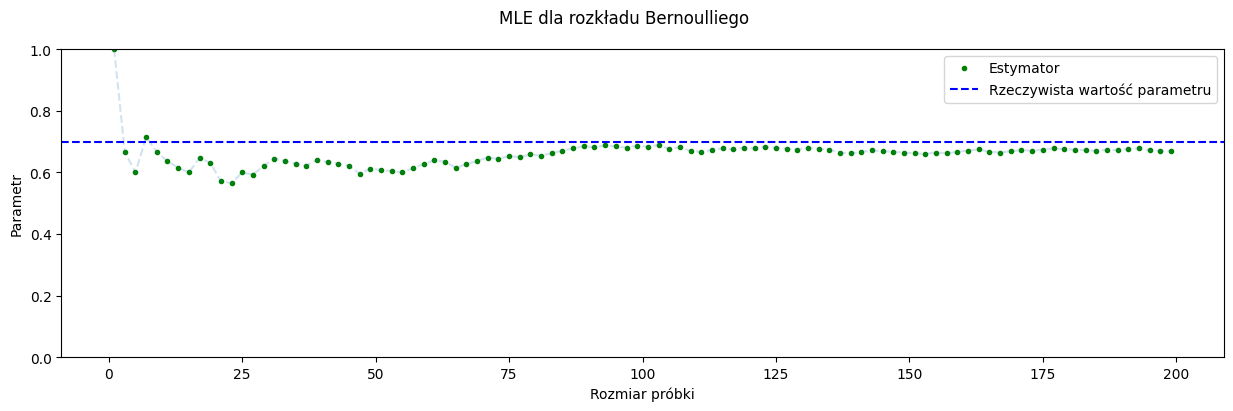

In [7]:
sample_sizes, p_mle_values = evaluate_at_intervals(
    data=coin_data[:200],  # Powyżej tej wartości estymator się nieznacznie zmienia
    step=2,
    fn=lambda d, i: mle_bernoulli(x=d[:i]),
)

plot_param_values(
    sample_sizes=sample_sizes,
    param_values=p_mle_values,
    true_param_value=p,
    title="MLE dla rozkładu Bernoulliego",
)

Widzimy zatem, że po zobserwowaniu zaledwie kilkunastu/kilkudziesięciu próbek estymator $\hat p$ zaczyna dobrze przybliżać wartość rzeczywistego parametru $p$. Należy jednak zauważyć, że początkowo wartości dość silnie się zmieniają. Zbadamy teraz jak zachowa się estymator $\hat p$, jeśli **początkowo będziemy obserwować w zbiorze same reszki ("0") a dopiero później będą się pojawiać orły ("1").**


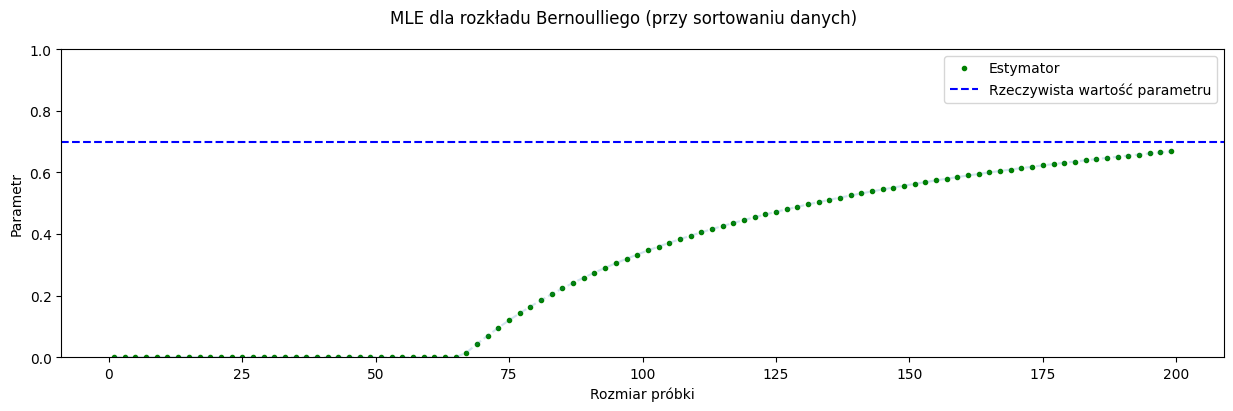

In [8]:
sample_sizes, p_mle_values = evaluate_at_intervals(
    data=sorted(coin_data[:200]),
    step=2,
    fn=lambda d, i: mle_bernoulli(x=d[:i]),
)

plot_param_values(
    sample_sizes=sample_sizes,
    param_values=p_mle_values,
    true_param_value=p,
    title="MLE dla rozkładu Bernoulliego (przy sortowaniu danych)",
)

Jak widzimy estymator MLE jest **czuły na próbę losową niezgodną z rzeczywistym rozkładem danych**. Należy zatem pamiętać, że w przypadku stosowania estymatora MLE musimy dysponować odpowiednio dużą próbką danych. Często niestety koszty pozyskiwania danych są spore, ale możemy sobie poradzić z taką sytuacją w inny sposób -- **zastosować estymator Maximum a Posteriori (MAP)**.


## Maximum a Posteriori Estimation


Przygotowywując modele zazwyczaj mamy pewną **intuicję** na temat tego, jakich wyników się można spodziewać (_ang. apriori knowledge_). W kontekście uczenia Bayesowskiego taką intuicję będziemy nazywać **rozkładem apriori** (lub w skrócie **prior**) i oznaczać go jako $g(\theta)$. Jest on określony dla wartości parametrów i wskazuje na to jak prawdopodobne są dane wartości parametrów modelu $\theta$.


Dobierając rozkład apriori do zadanej funkcji likelihood należy pamiętać o **rozkładach sprzężonych**, które pozwalają na uproszczenie obliczeń w modelu. Poniżej przestawiono wybrane rozkłady sprzężone:

| Likelihood                     | Conjugate Prior                   |
| :----------------------------- | :-------------------------------- |
| Bernoulli($p$)                 | Beta($\alpha$,$\beta$)            |
| Binomial($p$)                  | Beta($\alpha$,$\beta$)            |
| Poisson($\lambda$)             | Gamma($\alpha$,$\beta$)           |
| Categorical($\mathbf{p}$, $k$) | Dirichlet($\mathbf{\alpha}$, $k$) |
| Multinomial($\mathbf{p}$, $k$) | Dirichlet($\mathbf{\alpha}$, $k$) |


W podejściu Maximum a Posteriori chcemy wyznaczyć parametry modelu $\theta_{\text{MAP}}$, które maksymalizują funkcję **prawdopodobieństwa parametrów pod warunkiem obserwowanych danych** (nazywaną również **posterior**em):

$$\theta_\text{MAP} = \text{argmax}_{\theta} f(\theta | X_1, X_2, \ldots, X_n)$$

_Zauważ_: Estymator MLE stosuje "odwrotną" strategię, tzn. maksymalizuje prawdpodobieństwo obserwowania danych pod warunkiem określonych parametrów modelu.


Aby rozwiązać tak zdefiniowany problem optymalizacyjny, spróbujmy najpierw zastosować tzw. **regułę Bayesa**:

$$\theta_\text{MAP} = \text{argmax}_\theta \frac{f(X_1, X_2, \ldots, X_n | \theta) g(\theta)}{h(X_1, X_2, \ldots, X_n)},$$

gdzie $f(X_1, X_2, \ldots, X_n | \theta)$ to likelihood, $g(\theta)$ to prior, a $h(X_1, X_2, \ldots, X_n)$ reprezentuje prawdpodobieństwo obserwowania danych.

Należy podkreślić, że funkcja $h(\cdot)$ jest trudna w obliczeniu, ponieważ wymaga całkowania (sumowania) po całej dziedzinie możliwych wartości $\theta$. Nie będzie to jednak stanowiło tutaj problemu, ponieważ nie interesuje nas konkretna wartość posteriora, tylko chcemy go zmaksymalizować. Nie potrzebujemy $h(\cdot)$, a jako, że jest prawdopodobieństwem, to przyjmuje zawsze wartości nieujemne, więc możemy go pominąć w procesie maksymalizacji:

$$\theta_\text{MAP} = \text{argmax}_\theta f(X_1, X_2, \ldots, X_n | \theta) g(\theta)$$

Przypominając sobie dodatkowo, że dane są IID otrzymujemy:

$$\theta_\text{MAP} = \text{argmax}_\theta \prod_{i=1}^n f(X_i | \theta) g(\theta)$$

Podobnie jak w przypadku MLE możemy zastosować logarytm w celu uproszczenia obliczeń:

$$\theta_\text{MAP} = \text{argmax}_\theta \left( log(g(\theta)) + \sum_{i=1}^n log( f(X_i | \theta)) \right)$$


**Uwaga**: Zastosowanie MAP z rozkładem prior, który jest _non-informative_ (np. rozkład jednostajny na przedziale $[-\infty; +\infty]$) **jest równoważne** estymacji Maximum Likelihood, gdy $n\to\infty$

Zobacz również: [https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation#Example](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation#Example)


W celu wyznaczenia $\theta_\text{MAP}$ należy obliczyć pochodną powyższej funkcji (posterior; $\text{Pt}$) ze względu na parametry $\theta$ i przyrównać ją do zera:

$$ \text{Pt} = log(g(\theta)) + \sum\_{i=1}^n log( f(X_i | \theta)) $$

$$ \frac{\partial \text{Pt}}{\partial \theta} = 0$$

Zatem otrzymujemy:

$$ \frac{\partial}{\partial \theta}log(g(\theta)) + \frac{\partial}{\partial \theta} \sum\_{i=1}^n log( f(X_i | \theta)) = 0$$


### Powrót do przykładu - rozkład Beta


W przykładowym problemie wielokrotnego rzutu monetą założyliśmy, że likelihood może zostać zamodelowany za pomocą rozkładu Bernoulliego. Korzystając z tabeli rozkładów sprzężonych, widzimy że powinniśmy dobrać **rozkład Beta** jako prior.

Rozkład Beta jest określony wzorem:

$$\text{Beta}(\theta|\alpha, \beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} \theta^{\alpha -1} (1 - \theta)^{\beta - 1},$$

gdzie $\alpha, \beta$ to hiperparametry tego rozkładu a $\Gamma(\cdot)$ to funkcja Gamma.


### Zadanie 1 (1 pkt)

W komórce poniżej oblicz pochodną logarytmu funkcji rozkładu Beta ze względu na $\theta$:

$$\tag{1} \frac{\partial}{\partial \theta} log Beta(\theta|\alpha, \beta) = $$


![zad1](zad-1.png)


Przy okazji wyprowadzeń do MLE uzyskaliśmy już pochodną logarytmu likelihood'u (rozkład Bernoulliego):

$$\tag{2}\frac{\partial LL(X|\theta)}{\partial \theta}  = \frac{1}{\theta} \sum_{i=1}^n X_i - \frac{1}{1-\theta} (n - \sum_{i=1}^n X_i)$$


### Zadanie 2 (1 pkt)

Podstaw wartości $(1)$ oraz $(2)$ do wzoru na estymację MAP i wyprowadź wzór na $\theta_\text{MAP}$:


TU WPISZ ODPOWIEDŹ


### Zadanie 3 (0.5 pkt)

Zaimplementuj MAP zgodnie z wyprowadzonym wzorem. W poniższym kodzie przyjęto, że moneta jest (jak większość) symetryczna i jej zachowanie można opisać rozkładem $\text{Beta}(2, 2)$. Obliczono również wartość estymatora MAP dla wygenerowanego zbioru danych `coin_data`.


In [ ]:
def beta_bernoulli_map(x: np.ndarray, alpha: float, beta: float) -> float:
    # TU WPISZ KOD
    raise NotImplementedError()


alpha = 2
beta = 2

p_map = beta_bernoulli_map(
    x=coin_data,
    alpha=alpha,
    beta=beta,
)

display(Markdown(f"$p_{{MAP}} = {p_map:.4f}$"))

### Zadanie 4 (0.5 pkt)

Zbadaj zachowanie estymatora MAP dla różnych rozmiarów próbki danych. Wykorzystaj (i przerób) kod użyty w przykładzie z MLE. Zapisz obserwacje.


In [ ]:
# TU WPISZ KOD
raise NotImplementedError()

Obserwacje (wpisz w poniższej komórce):


TU WPISZ ODPOWIEDŹ


### Zadanie 5 (0.5 pkt)

Zbadaj zachowanie estymatora MAP w przypadku obserowania na początku tylko samych "0" a dopiero później "1". Wykorzystaj (i przerób) kod z estymacji MLE. Powtórz eksperyment dla priora $\text{Beta}(20, 20)$ oraz $\text{Beta}(100, 100)$. Zapisz obserwacje.


In [ ]:
# TU WPISZ KOD
raise NotImplementedError()

Obserwacje (wpisz w poniższej komórce):


TU WPISZ ODPOWIEDŹ


### Przyrostowe uczenie (online learning)


Jeśli dane napływają w czasie rzeczywistym, to chcielibyśmy mieć sposób na aktualizację parametrów modelu na podstawie pojedynczych nowych próbek danych, ponieważ ponowne przeliczanie estymat parametrów "od zera" może być dla większych modeli dość czasochłonne. **Online learning** pozwala na takie podejście do aktualizacji wartości parametrów. Formalnie możemy to zapisać jako:

$$\tag{3} \theta_\text{MAP}^{(n+1)} = u(\theta_\text{MAP}^{(n)}, x_{n+1}),$$

gdzie $\theta_\text{MAP}^{(n+1)}$ to zaktualizowane wartości parametrów ($n+1$ próbek), $\theta_\text{MAP}^{(n)}$ to poprzednie wartości parametrów ($n$ próbek), a $u(\cdot, x_{n+1})$ to funkcja zaktualizująca wartości parametrów w oparciu o poprzednią wartość parametrów oraz nową próbkę danych.


#### Zadanie 6 (1 pkt)

Korzystając ze wzoru na MAP dla modelu Beta-Bernoulli oraz powyższego wzoru $(3)$ na uczenie przyrostowe, wyznacz wzór na $\theta_\text{MAP}^{(n+1)}$ w taki sposób, aby wykorzystać jak najwięcej obliczeń z poprzedniego kroku $\theta_\text{MAP}^{(n)}$. Rozpisz dokładną procedurę aktualizacji wartości parametrów.


Wzór na $\theta_\text{MAP}^{(n+1)}$ (wpisz w poniższej komórce):


TU WPISZ ODPOWIEDŹ


Algorytm aktualizacji parametrów (wpisz w poniższej komórce):


TU WPISZ ODPOWIEDŹ


### Zadanie 7 (1 pkt)

Zaimplementuj podejście przyrostowe oraz sprawdź, że daje ono takie same wyniki (lub bardzo zbliżone) jak w przypadku obliczania wartości estymatora MAP od zera.


In [ ]:
class OnlineMAP:
    def __init__(self, alpha: int, beta: int):
        self._alpha = alpha
        self._beta = beta

        # TU WPISZ KOD
        raise NotImplementedError()

    def _map(self):
        # TU WPISZ KOD
        raise NotImplementedError()

    def update(self, x_i):
        # TU WPISZ KOD
        raise NotImplementedError()

        return self

In [ ]:
# testy ukryte

In [ ]:
sample_sizes, p_map_full_values = evaluate_at_intervals(
    data=coin_data[:50],
    step=1,
    fn=lambda d, i: beta_bernoulli_map(x=d[: i + 1], alpha=10, beta=10),
    start=0,
)

plot_param_values(
    sample_sizes=sample_sizes,
    param_values=p_map_full_values,
    true_param_value=p,
    title=f"MAP dla rozkładu Beta-Bernoulliego (pełne obliczenia)",
)

online_map = OnlineMAP(alpha=10, beta=10)

sample_sizes, p_map_online_values = None, None

# TU WPISZ KOD
raise NotImplementedError()

plot_param_values(
    sample_sizes=sample_sizes,
    param_values=p_map_online_values,
    true_param_value=p,
    title=f"MAP dla rozkładu Beta-Bernoulliego (przyrostowe uczenie)",
)


# Oblicz różnice wartości
diff = None

# TU WPISZ KOD
raise NotImplementedError()

print("Differences:", diff)